In [1]:
import sklearn.datasets
import numpy as np
from numpy.linalg import norm
from scipy.spatial.distance import hamming
from scipy.special import softmax
from scipy.ndimage import zoom
from skimage.measure import block_reduce
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import pickle

NUM_FEATURES = 784

TRAIN_SUBSET = 50000
TEST_SUBSET = 20000
FMR = False # if false then RMR

In [2]:
dataset = sklearn.datasets.fetch_openml("mnist_784", version=1)

In [3]:
X = dataset.data.to_numpy()
y = dataset.target.to_numpy()

In [4]:
def randomVector(n):
    """
    Randomly generates hypervector of size n
    """
    return (2*np.random.randint(0, 2, n)) - 1

def bind(a, b):
    return np.multiply(a, b)

def randomFlip(vec, idxs):
    """
    Returns a vector with the inx bits flipped.
    """
    assert len(idxs) <= len(vec), "Number of bits to flip greater than vector length"
    
    flipped_vec = np.copy(vec)
    
    for i in idxs:
        flipped_vec[i] *= -1
        
    return flipped_vec
    
def cosSim(a, b):
    """
    Performs cosine similarity on vectors a and b
    """
    
    if norm(a) == 0 or norm(b) == 0:
        return 0
    else:
        return (np.dot(a, b) / (norm(a) * norm(b)))

def hammingDist(a, b):
    """
    Normalized hamming distance between two vectors.
    Vectors are assumed to be binarized.
    """
    assert len(a) == len(b), "Vectors are not the same length"
    #return hamming(a, b)
    return np.count_nonzero(a!=b) / len(a)

def compareVectors(X):
    """
    Generates a heatmap comparing each vector to all other vectors
    """
    mat = np.zeros((len(X), len(X)))
    for i, x1 in enumerate(X):
        for j, x2 in enumerate(X):
            mat[i][j] = hammingDist(x1, x2)
            
    return mat

In [5]:
def buildLevelVectors(levels, dim):
    """
    Level hypervectors, level hypervector at i is copied from level hypervector i-1 with D/(2*255) bits flipped
    """
    levelvectors = []
    min_vector = randomVector(dim)
    
    levelvectors.append(min_vector)
    
    window = 0
    indexes = np.arange(0, dim)
    np.random.shuffle(indexes)
    bit_flips = int(dim/(2*255))

    for i in range(1, levels):
        mid_vec = np.copy(levelvectors[i-1])
        mid_vec = randomFlip(mid_vec, indexes[window:window+bit_flips])
        window += bit_flips
        
        levelvectors.append(mid_vec)
        
    return np.array(levelvectors)

def buildPosVectors(n, dim):
    """
    Array of n random hypervectors to encode position of features.
    """
    posvectors = []
    for i in range(n):
        posvectors.append(randomVector(dim))
    return np.array(posvectors)

def rmrBinarize(x):
    """
    Random majority rule. 0 are randomly set to 1 or -1
    """
    h = [i/abs(i) if i != 0 else np.random.choice([-1.0, 1.0]) for i in x]
    return np.array(h)

def fmrBinarize(x, k):
    """
    Fixed majority rule. 0 are set to k
    """
    h = [i/abs(i) if i != 0 else k for i in x]
    return np.array(h)

In [7]:
class Encoder:
    def __init__(self, dim, n_features, binarizer, load=True):
        self.D = dim
        self.n_features = n_features
        if load:
            self.loadClasses()
        else:
            self.B = buildPosVectors(n_features, dim)
            self.levelvectors = buildLevelVectors(256, dim)
        self.binarizer = binarizer        
        self.classvecs = {}
        
    def saveClasses(self):
        with open('classvectorsfmr.pickle', 'wb') as handle:
            pickle.dump(self.classvecs, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
        with open('posvectorsfmr.pickle', 'wb') as handle:
            pickle.dump(self.B, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
        with open('levelvectorsfmr.pickle', 'wb') as handle:
            pickle.dump(self.levelvectors, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
    def loadClasses(self):
        with open('classvectorsfmr.pickle', 'rb') as handle:
            self.classvecs = pickle.load(handle)
            
        with open('posvectorsfmr.pickle', 'rb') as handle:
            self.B = pickle.load(handle)

        with open('levelvectorsfmr.pickle', 'rb') as handle:
            self.levelvectors = pickle.load(handle)
        
    def binarize(self, x):
        if self.binarizer == 'rmr':
            return rmrBinarize(x)
        else:
            return fmrBinarize(x, -1)
    
    def encodeVector(self, X):
        h = np.zeros(self.D)
        for i, feature in enumerate(X):
            h += bind(self.levelvectors[int(feature)], self.B[i])
        
        return self.binarize(h)
    
    def train(self, X, y):
        assert len(X) == len(y), "len(X) len(y) not equal"
        
        #Encode and add all train data
        for i, obs in enumerate(X):
            target = y[i]
            h = self.encodeVector(obs)
            if target not in self.classvecs.keys():
                self.classvecs[target] = h
            else:
                self.classvecs[target] += h
                
        #Binarize classvectors
        for key, val in self.classvecs.items():
            self.classvecs[key] = self.binarize(val)
                
    def predict(self, x):
        h = self.encodeVector(x)
        dists = {}
        min_dist = None
        min_key = None
        
        for key, val in self.classvecs.items():
            score = hammingDist(h, val)
            dists[key] = score
            if min_dist == None or min_dist > score:
                min_dist = score
                min_key = key
            
        return min_key, dists
    
    def predictAll(self, X, y):
        correct_matrix = np.zeros((10,10))
        acc = 0.0
        for i, x in enumerate(X):
            pred, _ = self.predict(x)
            if pred == y[i]:
                acc += 1.0
            correct_matrix[int(y[i])][int(pred)] += 1
        
        acc = acc / len(X)
        return acc, correct_matrix

In [8]:
encoder = Encoder(10240, NUM_FEATURES, 'frm' if FMR else 'rmr')

## Train from scratch

In [8]:
start = time.time()
encoder.train(X[0:TRAIN_SUBSET], y[0:TRAIN_SUBSET])
end = time.time()
print("%f seconds elapsed. Avg %f seconds per observation" % (end-start, (end-start) / TRAIN_SUBSET))

959.540713 seconds elapsed. Avg 0.019191 seconds per observation


## Load classvectors

In [22]:
encoder.loadClasses()

## Figure 2 from the paper

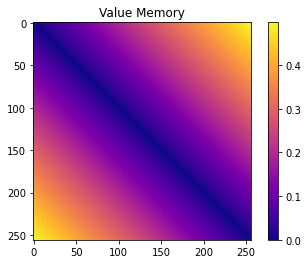

In [23]:
levelmat = compareVectors(encoder.levelvectors)
plt.imshow(levelmat, cmap='plasma', interpolation='nearest')
plt.title("Value Memory")
plt.colorbar()
plt.show()

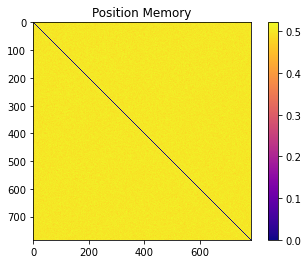

In [24]:
levelmat = compareVectors(encoder.B)
plt.imshow(levelmat, cmap='plasma', interpolation='nearest')
plt.title("Position Memory")
plt.colorbar()
plt.show()

In [11]:
acc, mat = encoder.predictAll(X[TRAIN_SUBSET:TRAIN_SUBSET+TEST_SUBSET], y[TRAIN_SUBSET:TRAIN_SUBSET+TEST_SUBSET])

Test Accuracy: 0.81725


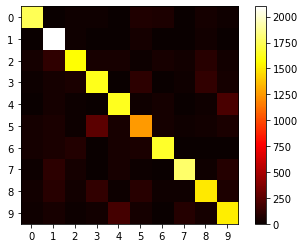

In [12]:
print(f"Test Accuracy: {acc}")
plt.imshow(mat, cmap='hot', interpolation='nearest')
plt.xticks(np.arange(0,10))
plt.yticks(np.arange(0,10))
plt.colorbar()
plt.show()

In [13]:
per_img_acc = np.zeros(len(mat))
for i in range(len(mat)):
    per_img_acc[i] = mat[i][i] / np.sum(mat[i])

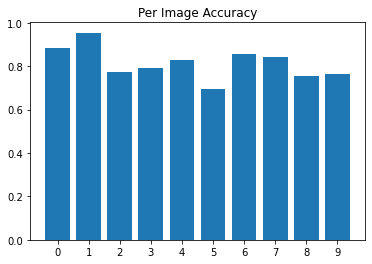

In [14]:
x_label = np.arange(0, 10)
plt.bar(x_label, per_img_acc)
plt.xticks(x_label)
plt.title("Per Image Accuracy")
plt.show()

## Save

In [15]:
encoder.saveClasses()

## Genetic Algorithm

In [9]:
def bestIncorrectLabel(label, dists):
    """
    Returns the minimum hamming distance of the image to any class hypervector that isn't the true label. Used in the objective function
    """
    min_dist = None
    min_key = None
    
    for d in dists.keys():
        if d != label:
            if min_dist == None or min_dist > dists[d]:
                min_dist = dists[d]
                min_key = d
                
    return min_dist, min_key

In [10]:
#g(X, t) Objective Function. Equation 1 in paper
def g(f: Encoder, X, t, epsilon):
    pred_label, pred_dist = f.predict(X)
    
    #Find the next most confident prediction
    min_fx, _ = bestIncorrectLabel(t, pred_dist)
    ftx = pred_dist[pred_label]

    #Epsilon term prevents adding more noise if prediction is already wrong
    return max(min_fx - ftx, -epsilon)

#Fitness function (Actual fitness is additive inverse of this). Equation 2 in paper.
def fitness(encoder, X_adverse, X, t, c, epsilon):
    X_diff = np.linalg.norm(X_adverse - X)
    return g(encoder, X_adverse, t, epsilon) + (c * X_diff)

In [11]:
def randomNoise(X, theta):
    """
    Perturb X with uniform random noise from (-theta, theta). Output clamped from 0, 255
    """
    noise = np.random.randint(low=-theta, high=theta, size=len(X))
    X_p = X + noise
    X_p = np.clip(X_p, 0, 255)
    return X_p

def maxPool(X):
    """
    Performs 2x2 max pooling on X and then upsamples to original size
    """
    X_p = X.reshape(28, 28)
    X_p = block_reduce(X_p, (2,2), np.max)
    X_p = zoom(X_p, 2, order=0)
    return X_p.reshape(784)

def initPopulation(X, N, theta):
    """
    Creates N adversarial images of X
    """
    pop = []
    for i in range(N):
        X_member = randomNoise(X, theta)
        pop.append(X_member)
        
    return pop

def chooseWeightedPair(weights):
    """
    Randomly choose two indices with corresponding weight
    """
    indices = np.arange(len(weights))
    pair = np.random.choice(indices, size=2, replace=False, p=weights)
    return pair[0], pair[1]

In [12]:
def criticalGeneCrossover(parent1, parent2, p, mutation_dist, mutation_prob, beta):
    child = np.copy(parent1)
    child = child.reshape(28, 28)
    
    child_ = maxPool(child)
    child_ = (child_ - np.min(child_))/(np.max(child))
    child = child.reshape(784)
    
    
    for idx in range(len(child_)):
        if child_[idx] > beta:
            #Take from parent
            child[idx] = p*parent1[idx] + (1-p)*parent2[idx]
            
            #Mutate
            child[idx] = child[idx] + np.random.choice(a=[0,1], p=[1-mutation_prob, mutation_prob])*np.random.uniform(-mutation_dist, mutation_dist)
    
    
    child = np.clip(child, 0, 255)
    #plt.imshow(1 - child.reshape(28, 28), cmap='gray')
    #plt.axis("off")
    #plt.show()
    return child

def perturbationAdjustment(X_ori, X_adv, t, encoder):
    #Index list of changed pixels
    X_adj = np.copy(X_adv)
    
    L = []
    for i in range(len(X_ori)):
        if X_ori[i] != X_adv[i]:
            L.append(i)  
    
    for p in L:
        v_ori = int(X_ori[p])
        v_adv = int(X_adv[p])
        for v in range(v_ori, v_adv + 1):
            X_adj[p] = float(v)
            pred, _ = encoder.predict(X_adj)
            if pred != t:
                break
                
    return X_adj

In [13]:
def genetic(X, t, N, Imax, theta, epsilon, c, mutation_theta, mutation_prob, beta, encoder):
    """
    Original image: X
    True label: t
    Population size: N
    Maximum iterations: Imax
    Random noise range: theta
    Objective function term: epsilon
    Fitness regularization: c
    Mutation noise range: mutation_theta
    Mutation probability: mutation_prob
    beta: "Critical Gene threshold" for a pixel to be considered for mutation
    Encoder: encoder
    """
    G_curr = initPopulation(X, N, theta)
    X_n = np.array([None])
    for i in range(Imax):
        #Fitness score of each member
        pop_fitness = [-fitness(encoder, member, X, t, c, epsilon) for member in G_curr]
        #print("Fitness")
        #print(pop_fitness)
        #Get elite member
        elite = G_curr[np.argmax(pop_fitness)]
        G_next = [elite]
        
        if i % 10 == 0:
            print(f"{i}/{Imax}: {-fitness(encoder, elite, X, t, c, epsilon)}")
            
            #plt.imshow(1-(elite.reshape(28, 28)), cmap='gray')
            #plt.axis("off")
            #plt.savefig(f"gen_{i}.jpg")
            #plt.show()
            
        
        pred_label, _ = encoder.predict(elite)
        if pred_label != t:
            print("Finished")
            X_n = elite
            break
        
        #Softmax of fitness scores as selection probability for mating
        P_sel = softmax(pop_fitness)

        for j in range(1, N):
            idx1, idx2 = chooseWeightedPair(P_sel)
            parent1 = G_curr[idx1]
            parent2 = G_curr[idx2]
            #print(f"Parents: {idx1} and {idx2}")
            #Probability distribution found by dividing fitness of p1 by sum of fitness beween p1 and p2
            p = pop_fitness[idx1] / (pop_fitness[idx1] + pop_fitness[idx2])
            #print(f"Probability distribution: {p}")
            
            #TODO Figure out numbers for Sigma max, mutation probability, and critical gene threshold
            child = criticalGeneCrossover(parent1=G_curr[idx1],
                                          parent2=G_curr[idx2],
                                          p=p,
                                          mutation_dist=mutation_theta,
                                          mutation_prob=mutation_prob,
                                          beta=beta)
            G_next.append(child)
        
        G_curr = G_next
        
    #If still empty
    if X_n.any() == None:
        print(f"Stopped unsuccessfully after {Imax} iterations")
        X_n = G_curr[0]
    else:
        X_n = perturbationAdjustment(X, X_n, t, encoder)
    return X_n

('9', {'5': 0.09853515625, '0': 0.1208984375, '4': 0.0822265625, '1': 0.113671875, '9': 0.074609375, '2': 0.109765625, '3': 0.10986328125, '6': 0.0986328125, '7': 0.09033203125, '8': 0.0986328125})


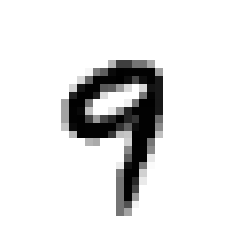

In [25]:
#Test Images for testing
test_X = X[116]
test_y = y[116]
print(encoder.predict(test_X))
img = test_X.reshape(28, 28)

plt.imshow(1 - img, cmap='gray')
plt.axis("off")
plt.show()

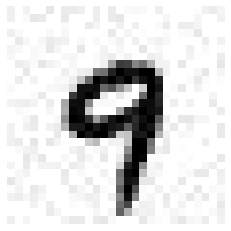

In [26]:
#Testing Noise Generation
perturbed_X = randomNoise(test_X, 25)
img_p = perturbed_X.reshape(28, 28)
plt.imshow(1 - img_p, cmap='gray')
plt.axis("off")
plt.show()

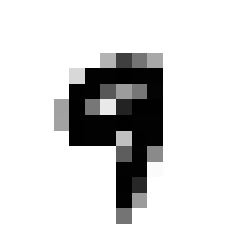

In [27]:
#Testing Max Pooling
pooled_X = maxPool(test_X)
img_pooled = pooled_X.reshape(28, 28)
plt.imshow(1 - img_pooled, cmap='gray')
plt.axis("off")
plt.show()

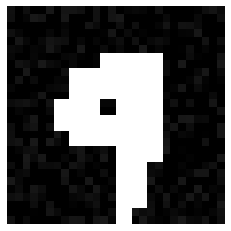

In [28]:
#Test max pooling + critical genes
critical_X = maxPool(perturbed_X)
critical_X = np.abs((critical_X - np.min(critical_X))/(np.max(critical_X)))

#print(critical_X)

X2 = np.copy(perturbed_X)
X2[critical_X > 0.1] = 255

img_critical = X2.reshape(28, 28)


plt.imshow(img_critical, cmap='gray')
plt.axis("off")
plt.show()

In [32]:
def differenceImage(orig, winner):
    return np.abs(winner - orig)

def saveImage(array, name):
    img = array.reshape(28, 28)
    plt.imsave(name, img, cmap='gray')
    
def saveImages(orig, winner, diff, digit_choice):
    path = "FigureImagesFMR" if FMR else "FigureImagesRMR"
    saveImage(orig, f"FigureImagesFMR/{digit_choice}_original.png")
    saveImage(winner, f"FigureImagesFMR/{digit_choice}_perturbed.png")
    saveImage(diff, f"FigureImagesFMR/{digit_choice}_difference.png")

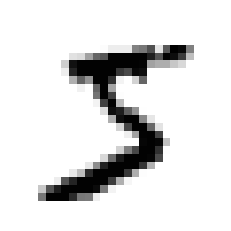

0/10000: -0.00011263658375501274
Finished


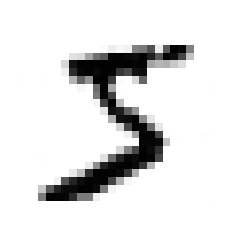

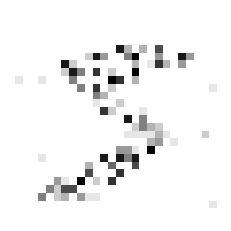

True label: 5
Predicted label: 3
# Modified Pixels: 88
L2 Difference: 50.20956084253277
Linf Difference: 10.0


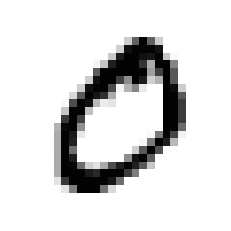

0/10000: -0.02951046226396951
10/10000: -0.02793908277194753
20/10000: -0.02277218291623592
30/10000: -0.023793145265892233
40/10000: -0.024458965854490075
50/10000: -0.02331855253265622
60/10000: -0.022389615270856828
70/10000: -0.02343818677950997
80/10000: -0.022327867052526436
90/10000: -0.020261208176664627
100/10000: -0.01968883674097083
110/10000: -0.019102899240970837
120/10000: -0.0206904911399014
130/10000: -0.021120310187534987
140/10000: -0.019185722550776045
150/10000: -0.01805331839026559
160/10000: -0.016888575801937655
170/10000: -0.01575358513559468
180/10000: -0.015607939037414318
190/10000: -0.013076547087814144
200/10000: -0.012881234587814141
210/10000: -0.014072727884747224
220/10000: -0.013291477884747226
230/10000: -0.013357934523506174
240/10000: -0.01123242085815018
250/10000: -0.011623045858150185
260/10000: -0.012404295858150182
270/10000: -0.01163255087839389
280/10000: -0.011046613378393882
290/10000: -0.010505303867795291
300/10000: -0.010125012596573132


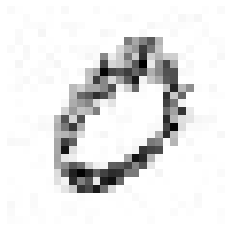

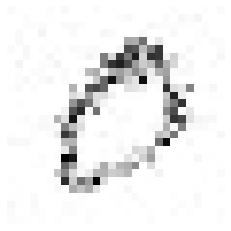

True label: 0
Predicted label: 5
# Modified Pixels: 387
L2 Difference: 1291.80981288364
Linf Difference: 228.19628013667443


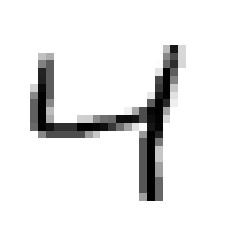

0/10000: -0.008709900764095634
10/10000: -0.007591197724336922
20/10000: -0.007844402448895333
30/10000: -0.00643327276852144
40/10000: -0.006636595240623318
50/10000: -0.007265825663294053
60/10000: -0.006593998684046225
70/10000: -0.008018947173045443
80/10000: -0.006277944318226843
90/10000: -0.006093241913022898
100/10000: -0.0064921264701037545
110/10000: -0.006296813970103752
120/10000: -0.005740741696202454
130/10000: -0.005593742100781738
140/10000: -0.00561835803093244
150/10000: -0.005651703689293289
160/10000: -0.004481728665393854
170/10000: -0.0043199827110283
180/10000: -0.005308845491974956
190/10000: -0.005894782991974964
200/10000: -0.005539891813676806
210/10000: -0.004199862549459206
220/10000: -0.005412626820305147
230/10000: -0.0038471896523114618
240/10000: -0.00365212669811204
250/10000: -0.004495454255976372
260/10000: -0.0060710842658655275
270/10000: -0.003911104786042654
280/10000: -0.003923267595408278
290/10000: -0.00452894562570749
300/10000: -0.0053080254

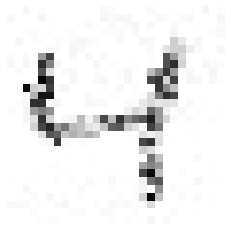

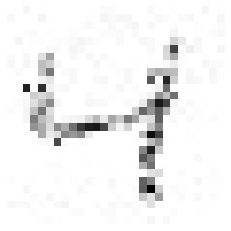

True label: 4
Predicted label: 5
# Modified Pixels: 355
L2 Difference: 1186.1144193316065
Linf Difference: 255.0


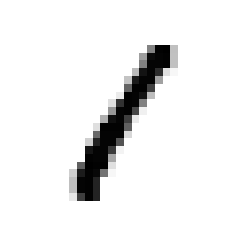

0/10000: -0.01340086605243444
10/10000: -0.012341684208388331
20/10000: -0.013240674458060462
30/10000: -0.012254134519883981
40/10000: -0.01196008330187271
50/10000: -0.013141410764857185
60/10000: -0.013144335919811673
70/10000: -0.011278421645841792
80/10000: -0.01230855985675593
90/10000: -0.012920819776514585
100/10000: -0.010598855946423368
110/10000: -0.010228444492671043
120/10000: -0.0102657484304709
130/10000: -0.013370368831602615
140/10000: -0.01203081155467837
150/10000: -0.010869200016956713
160/10000: -0.010090975184377404
170/10000: -0.011474311770505525
180/10000: -0.0111128342398797
190/10000: -0.010362309356099931
200/10000: -0.010362609957693553
210/10000: -0.008636706155154019
220/10000: -0.008472463557475907
230/10000: -0.006169213949746933
240/10000: -0.0065598389497469245
250/10000: -0.007145776449746933
260/10000: -0.006169213949746933
270/10000: -0.007558180566138488
280/10000: -0.006383995729108593
290/10000: -0.008729132367996523
300/10000: -0.00892444486799

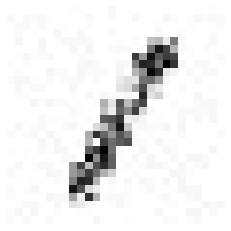

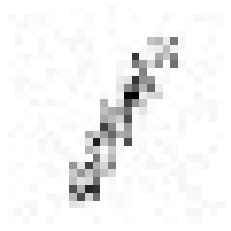

True label: 1
Predicted label: 2
# Modified Pixels: 435
L2 Difference: 1066.2605683641934
Linf Difference: 251.0


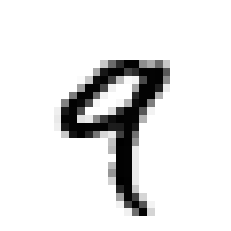

0/10000: -0.007537347940553182
10/10000: -0.0063191487548944145
20/10000: -0.005537898754894403
30/10000: -0.006976081655737155
40/10000: -0.007445258827314678
50/10000: -0.007304789973764191
60/10000: -0.005617451706419419
70/10000: -0.00525835044847265
80/10000: -0.00525251703708518
90/10000: -0.005340416904499498
100/10000: -0.005917080003226082
110/10000: -0.0036568498578430837
120/10000: -0.0042710593447169865
130/10000: -0.0035110480285920633
140/10000: -0.001990997419674303
150/10000: -0.0018120696757186333
Finished


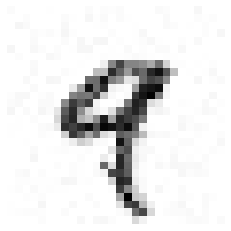

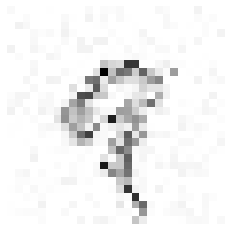

True label: 9
Predicted label: 4
# Modified Pixels: 420
L2 Difference: 711.4168254117942
Linf Difference: 166.7385317079315


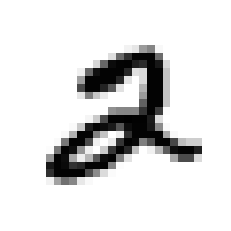

0/10000: -0.0005104206593537567
Finished


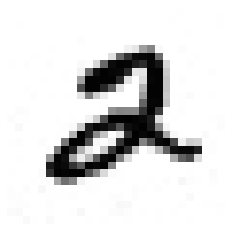

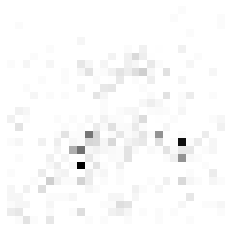

True label: 2
Predicted label: 9
# Modified Pixels: 262
L2 Difference: 104.70588279966341
Linf Difference: 53.15599331232937


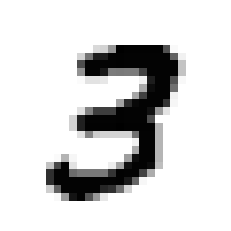

0/10000: -0.000606813945911297
Finished


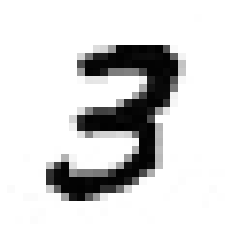

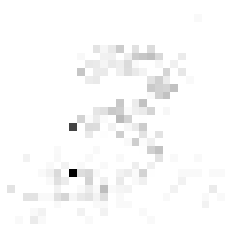

True label: 3
Predicted label: 8
# Modified Pixels: 172
L2 Difference: 69.22962188705229
Linf Difference: 37.07325929195618


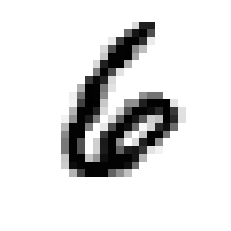

0/10000: -0.013990065488264786
10/10000: -0.014285044196250958
20/10000: -0.010839555874963833
30/10000: -0.01147024443678037
40/10000: -0.01029876864827674
50/10000: -0.008781084615216168
60/10000: -0.007802643137902971
70/10000: -0.008629538652054899
80/10000: -0.004779423740651766
90/10000: -0.005560673740651777
100/10000: -0.005985906670650003
110/10000: -0.0050285216465825785
120/10000: -0.005612921051776323
130/10000: -0.00409441936983743
140/10000: -0.005266294369837433
150/10000: -0.004100356711023598
160/10000: -0.0066972001606177434
170/10000: -0.005742768202265499
180/10000: -0.005213433193585847
190/10000: -0.00736795542844234
200/10000: -0.00450173445772522
210/10000: -0.005490206419062731
220/10000: -0.007067542245780411
230/10000: -0.004179674678681172
240/10000: -0.0034265559291168516
250/10000: -0.005420804800737003
260/10000: -0.005758379464609153
270/10000: -0.005206080919122728
280/10000: -0.00462523489600995
290/10000: -0.004228205312620165
300/10000: -0.0050100757

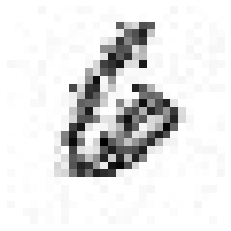

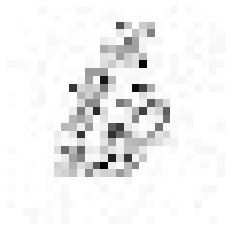

True label: 6
Predicted label: 2
# Modified Pixels: 444
L2 Difference: 1084.431076967026
Linf Difference: 232.24729105798002


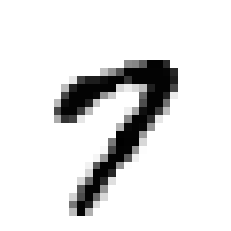

0/10000: -0.00724679178770501
10/10000: -0.0068723528594633165
20/10000: -0.0055610606804729346
30/10000: -0.007415219298763507
40/10000: -0.004741014368024232
50/10000: -0.00477229989709563
60/10000: -0.0042232662052419994
70/10000: -0.004686309864332801
80/10000: -0.005490107500317075
90/10000: -0.003967412483498588
100/10000: -0.004206681048503901
110/10000: -0.003424760580045397
120/10000: -0.002452679810752363
130/10000: -0.00225736731075236
140/10000: -0.0024568103431696674
150/10000: -0.00265212284316967
160/10000: -0.003275068139311838
170/10000: -0.004283577608075947
180/10000: -0.002763831342037587
190/10000: -0.002805973180443004
Finished


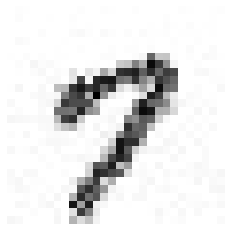

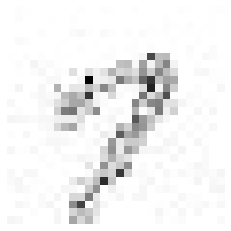

True label: 7
Predicted label: 9
# Modified Pixels: 443
L2 Difference: 897.2403053614992
Linf Difference: 214.92157494216474


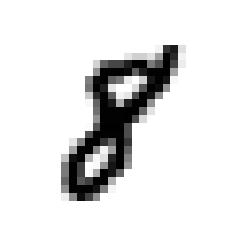

0/10000: -0.010950951805513535
10/10000: -0.010126147228655874
20/10000: -0.010222796734902203
30/10000: -0.007933620469978747
40/10000: -0.00800187090216789
50/10000: -0.008451799704086074
60/10000: -0.0075261342300728794
70/10000: -0.0065495717300728794
80/10000: -0.007247020948257027
90/10000: -0.006520885647321105
100/10000: -0.005734776209735652
110/10000: -0.005586666435565532
120/10000: -0.005802578784155765
130/10000: -0.0067740238937876104
140/10000: -0.0058243191944124485
150/10000: -0.004899646168632899
160/10000: -0.004704333668632882
170/10000: -0.004313708668632891
180/10000: -0.004704333668632882
190/10000: -0.005327590472575421
200/10000: -0.003766842678202971
210/10000: -0.004192939311156697
220/10000: -0.0044369452586863955
230/10000: -0.003648683466393069
240/10000: -0.0038439959663930717
250/10000: -0.003504868778453791
260/10000: -0.0029626806177915866
270/10000: -0.003752503708922602
280/10000: -0.0029639087295379824
290/10000: -0.002584634256827303
300/10000: -0.

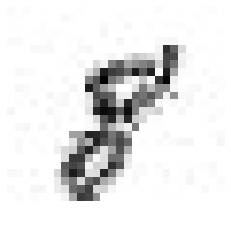

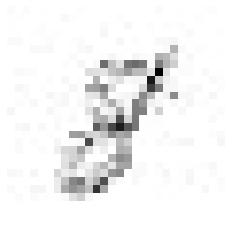

True label: 8
Predicted label: 5
# Modified Pixels: 368
L2 Difference: 1030.5830067050779
Linf Difference: 245.5848570751854


In [36]:
# guess until wrong
def repeat_guess(x, label):
    tries = 0
    pred = label
    while pred == label and tries < 100:
        pred, vecs = encoder.predict(x)
        tries += 1
    return pred, tries

def draw_image(x):
    img = x.reshape(28, 28)
    plt.imshow(1 - img, cmap='gray')
    plt.axis("off")
    plt.show()

# stores indicies for each class label
digit_idxs = {}
for i, yi in enumerate(y):
    if yi not in digit_idxs:
        digit_idxs[yi] = []
    digit_idxs[yi].append(i)

ad_examples = {}

for d in digit_idxs:
    i = digit_idxs[d][0]
    test_X = X[i]
    test_y = y[i]
    draw_image(test_X)
    winner = genetic(X=test_X,
                 t=test_y,
                 N=6,
                 Imax=10000,
                 theta=10,
                 epsilon=0.50,
                 c=0.000001,
                 mutation_theta=100,
                 mutation_prob=0.05,
                 beta=0.2,
                 encoder=encoder)
    ad_examples[d] = winner
    diff = differenceImage(test_X, winner)
    draw_image(winner)
    draw_image(diff)
    pred, _ = repeat_guess(winner, test_y)
    print("True label:", test_y)
    print("Predicted label:", pred)
    print("# Modified Pixels:", np.sum(winner != test_X))
    print("L2 Difference:", np.linalg.norm(diff, ord=2)/255)
    print("Linf Difference:", np.linalg.norm(diff, ord=np.Inf)/255)
    saveImages(test_X, winner, diff, d)

In [38]:
def perImgAcc(encoder, image, label, trials):
    
    correct = 0.0
    
    for i in range(trials):
        pred, _ = encoder.predict(image)
        if pred == label:
            correct += 1.0
            
    return correct/trials

In [39]:
img_acc_benign = []
img_acc_adv = []

for i in range(10):
    d = str(i)
    idx = digit_idxs[d][0]
    test_X = X[idx]
    test_y = y[idx]
    winner = ad_examples[d]
    img_acc_benign.append(perImgAcc(encoder, test_X, test_y, 1000))
    img_acc_adv.append(perImgAcc(encoder, winner, test_y, 1000))

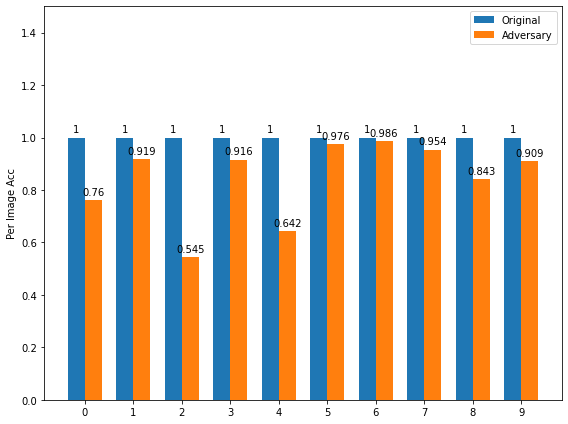

In [450]:
x = labels
width = 0.35
fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, img_acc_benign, width, label='Original')
rects2 = ax.bar(x + width/2, img_acc_adv, width, label='Adversary')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Per Image Acc')
ax.set_xticks(x, labels)
plt.ylim((0, 1.5))
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()